In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 50
CSV_FILE_PATH = 'gyroscope_data.csv'

def alineData(df):
    def alineDateWithLabel(label, df):
        lable_data = df[df['activity_type'] == label]
        return lable_data[0:lable_data.shape[0] - lable_data.shape[0] % MEASUREMENTS_PER_SAMPLE]
    
    return pd.concat([alineDateWithLabel(label, df) for label in df['activity_type'].unique()])

df = alineData(pd.read_csv(CSV_FILE_PATH))
samples_number = df.shape[0] // MEASUREMENTS_PER_SAMPLE

def prepareTargets(df):
    df = df[df.columns[-1:len(df.columns)]]
    
    def prepareTarget(sample_index):
        sample_start_index = sample_index * MEASUREMENTS_PER_SAMPLE
        sample_end_index = (sample_index + 1) * MEASUREMENTS_PER_SAMPLE
        
        targets = df[sample_start_index:sample_end_index]['activity_type'].unique()
        
        if(targets.size > 1):
            raise ValueError('Sample can not have more then one target')
        
        return targets[0] 
    
    return LabelBinarizer().fit_transform(np.array([prepareTarget(index) for index in range(0, samples_number)]))

def prepareSamples(df):
    return df[df.columns[0:-1]].values.reshape((samples_number, MEASUREMENTS_PER_SAMPLE, 6))

samples = prepareSamples(df)
targets = prepareTargets(df)

print(samples.shape)
print(targets.shape)

(1260, 50, 6)
(1260, 3)


In [3]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [4]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(756, 50, 6)
(756, 3)
(252, 50, 6)
(252, 3)
(252, 50, 6)
(252, 3)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.45))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [6]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse',
              metrics=['accuracy'])

In [7]:
history = model.fit(train_data,
                    train_labels,
                    epochs=350,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 756 samples, validate on 252 samples
Epoch 1/350
756/756 [==============================] - 0s 406us/step - loss: 0.4081 - acc: 0.3783 - val_loss: 0.4029 - val_acc: 0.3929
Epoch 2/350
756/756 [==============================] - 0s 73us/step - loss: 0.4009 - acc: 0.3862 - val_loss: 0.4048 - val_acc: 0.3770
Epoch 3/350
756/756 [==============================] - 0s 75us/step - loss: 0.4007 - acc: 0.3876 - val_loss: 0.4038 - val_acc: 0.3849
Epoch 4/350
756/756 [==============================] - 0s 77us/step - loss: 0.3880 - acc: 0.4048 - val_loss: 0.4021 - val_acc: 0.3929
Epoch 5/350
756/756 [==============================] - 0s 75us/step - loss: 0.3905 - acc: 0.4048 - val_loss: 0.4104 - val_acc: 0.3810
Epoch 6/350
756/756 [==============================] - 0s 76us/step - loss: 0.3868 - acc: 0.4153 - val_loss: 0.4111 - val_acc: 0.3810
Epoch 7/350
756/756 [==============================] - 0s 77us/step - loss: 0.3892 - acc: 0.4114 - val_loss: 0.4113 - val_acc: 0.3810
Epoch 8/350
756

756/756 [==============================] - 0s 71us/step - loss: 0.1462 - acc: 0.7659 - val_loss: 0.1594 - val_acc: 0.7460
Epoch 62/350
756/756 [==============================] - 0s 74us/step - loss: 0.1607 - acc: 0.7434 - val_loss: 0.1523 - val_acc: 0.7579
Epoch 63/350
756/756 [==============================] - 0s 72us/step - loss: 0.1471 - acc: 0.7659 - val_loss: 0.1614 - val_acc: 0.7421
Epoch 64/350
756/756 [==============================] - 0s 71us/step - loss: 0.1421 - acc: 0.7725 - val_loss: 0.1581 - val_acc: 0.7460
Epoch 65/350
756/756 [==============================] - 0s 77us/step - loss: 0.1516 - acc: 0.7593 - val_loss: 0.1561 - val_acc: 0.7421
Epoch 66/350
756/756 [==============================] - 0s 78us/step - loss: 0.1504 - acc: 0.7579 - val_loss: 0.1523 - val_acc: 0.7619
Epoch 67/350
756/756 [==============================] - 0s 83us/step - loss: 0.1450 - acc: 0.7659 - val_loss: 0.1575 - val_acc: 0.7500
Epoch 68/350
756/756 [==============================] - 0s 78us/step

756/756 [==============================] - 0s 81us/step - loss: 0.0663 - acc: 0.8810 - val_loss: 0.0614 - val_acc: 0.8810
Epoch 122/350
756/756 [==============================] - 0s 79us/step - loss: 0.0643 - acc: 0.8876 - val_loss: 0.0538 - val_acc: 0.8889
Epoch 123/350
756/756 [==============================] - 0s 77us/step - loss: 0.0634 - acc: 0.8810 - val_loss: 0.0692 - val_acc: 0.8651
Epoch 124/350
756/756 [==============================] - 0s 81us/step - loss: 0.0599 - acc: 0.8849 - val_loss: 0.0577 - val_acc: 0.8730
Epoch 125/350
756/756 [==============================] - 0s 83us/step - loss: 0.0672 - acc: 0.8664 - val_loss: 0.0712 - val_acc: 0.8571
Epoch 126/350
756/756 [==============================] - 0s 78us/step - loss: 0.0695 - acc: 0.8664 - val_loss: 0.0648 - val_acc: 0.8651
Epoch 127/350
756/756 [==============================] - 0s 70us/step - loss: 0.0554 - acc: 0.8995 - val_loss: 0.0558 - val_acc: 0.9048
Epoch 128/350
756/756 [==============================] - 0s 70

756/756 [==============================] - 0s 75us/step - loss: 0.0341 - acc: 0.9392 - val_loss: 0.0319 - val_acc: 0.9405
Epoch 182/350
756/756 [==============================] - 0s 70us/step - loss: 0.0353 - acc: 0.9325 - val_loss: 0.0318 - val_acc: 0.9524
Epoch 183/350
756/756 [==============================] - 0s 74us/step - loss: 0.0284 - acc: 0.9484 - val_loss: 0.0334 - val_acc: 0.9484
Epoch 184/350
756/756 [==============================] - 0s 75us/step - loss: 0.0363 - acc: 0.9312 - val_loss: 0.0259 - val_acc: 0.9603
Epoch 185/350
756/756 [==============================] - 0s 80us/step - loss: 0.0279 - acc: 0.9471 - val_loss: 0.0378 - val_acc: 0.9325
Epoch 186/350
756/756 [==============================] - 0s 70us/step - loss: 0.0281 - acc: 0.9458 - val_loss: 0.0293 - val_acc: 0.9524
Epoch 187/350
756/756 [==============================] - 0s 70us/step - loss: 0.0317 - acc: 0.9392 - val_loss: 0.0362 - val_acc: 0.9325
Epoch 188/350
756/756 [==============================] - 0s 70

756/756 [==============================] - 0s 84us/step - loss: 0.0227 - acc: 0.9550 - val_loss: 0.0209 - val_acc: 0.9563
Epoch 242/350
756/756 [==============================] - 0s 79us/step - loss: 0.0240 - acc: 0.9524 - val_loss: 0.0238 - val_acc: 0.9563
Epoch 243/350
756/756 [==============================] - 0s 79us/step - loss: 0.0128 - acc: 0.9802 - val_loss: 0.0264 - val_acc: 0.9484
Epoch 244/350
756/756 [==============================] - 0s 80us/step - loss: 0.0206 - acc: 0.9643 - val_loss: 0.0259 - val_acc: 0.9444
Epoch 245/350
756/756 [==============================] - 0s 75us/step - loss: 0.0147 - acc: 0.9749 - val_loss: 0.0224 - val_acc: 0.9603
Epoch 246/350
756/756 [==============================] - 0s 78us/step - loss: 0.0187 - acc: 0.9709 - val_loss: 0.0249 - val_acc: 0.9563
Epoch 247/350
756/756 [==============================] - 0s 83us/step - loss: 0.0187 - acc: 0.9656 - val_loss: 0.0249 - val_acc: 0.9563
Epoch 248/350
756/756 [==============================] - 0s 80

756/756 [==============================] - 0s 80us/step - loss: 0.0214 - acc: 0.9630 - val_loss: 0.0223 - val_acc: 0.9563
Epoch 302/350
756/756 [==============================] - 0s 84us/step - loss: 0.0158 - acc: 0.9696 - val_loss: 0.0183 - val_acc: 0.9683
Epoch 303/350
756/756 [==============================] - 0s 80us/step - loss: 0.0150 - acc: 0.9749 - val_loss: 0.0198 - val_acc: 0.9603
Epoch 304/350
756/756 [==============================] - 0s 77us/step - loss: 0.0140 - acc: 0.9735 - val_loss: 0.0179 - val_acc: 0.9722
Epoch 305/350
756/756 [==============================] - 0s 77us/step - loss: 0.0085 - acc: 0.9828 - val_loss: 0.0230 - val_acc: 0.9524
Epoch 306/350
756/756 [==============================] - 0s 72us/step - loss: 0.0145 - acc: 0.9749 - val_loss: 0.0219 - val_acc: 0.9603
Epoch 307/350
756/756 [==============================] - 0s 73us/step - loss: 0.0174 - acc: 0.9683 - val_loss: 0.0267 - val_acc: 0.9444
Epoch 308/350
756/756 [==============================] - 0s 74

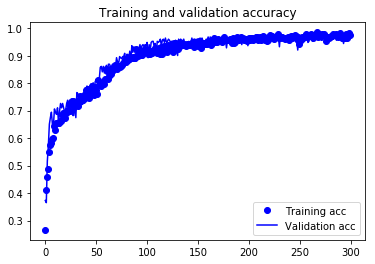

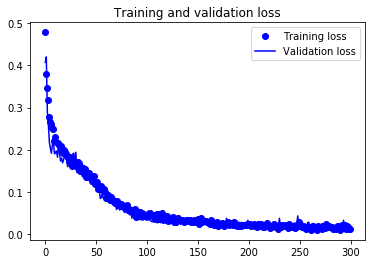

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
model.evaluate(test_data, test_labels)

252/252 [==============================] - 0s 39us/step


[0.030784319657536727, 0.9365079384001475]

In [10]:
model.predict(test_data[0:1])

array([[6.2228116e-07, 1.4772667e-07, 9.9999928e-01]], dtype=float32)